In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import glob 
import matplotlib.pyplot as plt
from collections import deque
import matplotlib.image as mpimg
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

Corners for img 1
Corners for img 2
Corners for img 3
Corners for img 4
Corners for img 5
Corners for img 6
Corners for img 7
Corners for img 8
Corners for img 9
Corners for img 10
Corners for img 11
Corners for img 12
Corners for img 13
Corners for img 16
Corners for img 17
Corners for img 18
Corners for img 19
Saved calibration file


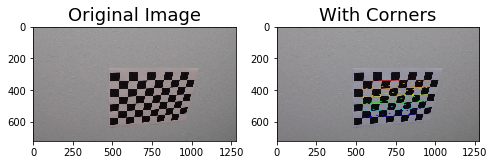

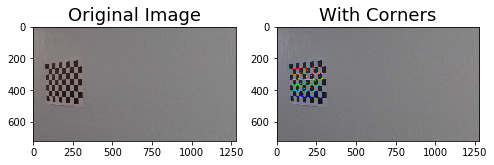

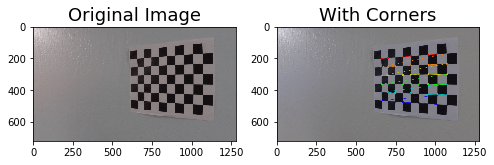

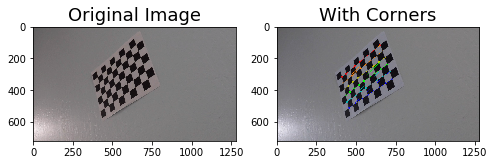

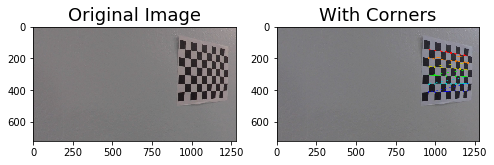

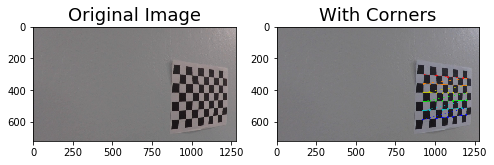

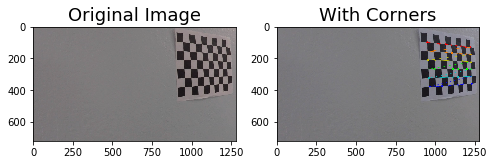

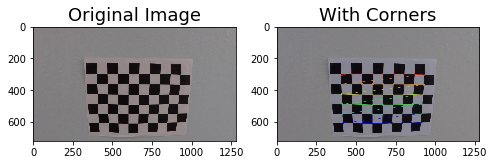

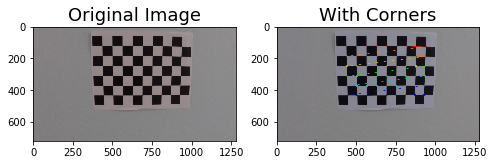

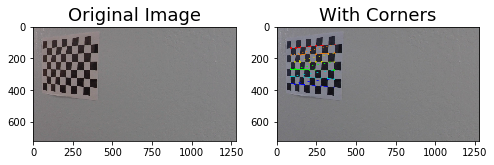

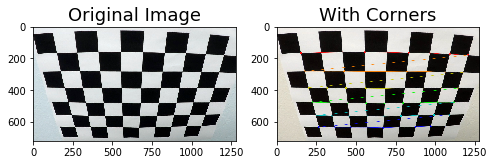

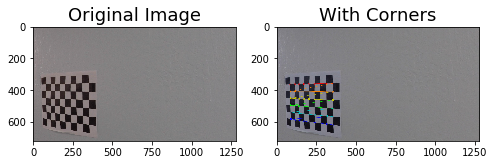

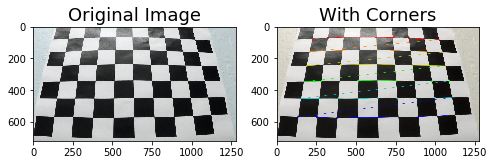

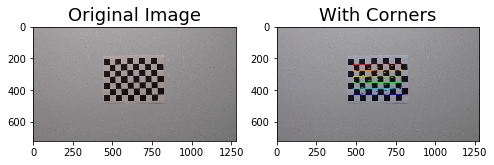

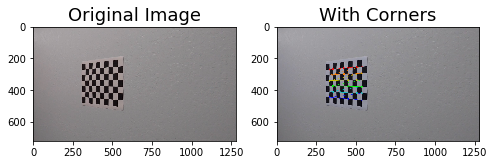

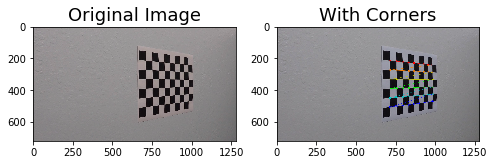

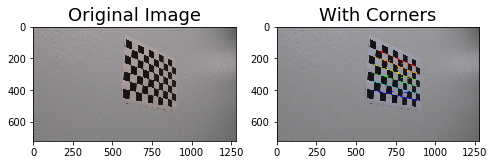

In [2]:
def read_images():
    #test_image_names = glob.glob('./camera_cal/calibration*.jpg')
    
    test_image_names = glob.glob('./test_images/*.jpg')
    test_images = []
    for test_image_name in test_image_names:
        image = plt.imread(test_image_name)
        test_images.append(image)
    return test_images
images = read_images()

#PARAMS
img_size = (images[0].shape[1], images[0].shape[0])
abs_sobel_orient = 'x'
abs_sobel_kernel = 15
abs_sobel_threshold = (24,100)
mag_sobel_kernel = 15
mag_sobel_threshold = (20,100)
dir_sobel_kernel = 31
dir_sobel_threshold = (0, np.pi/2)
rgb_thresh_channel = 'r'
rgb_thresh_threshold = (130,255)
hls_thresh_channel = 's'
hls_thresh_threshold = (110,255)
hsv_thresh_channel = 'h'
hsv_thresh_threshold = (0,110)
YCrCb_thresh_channel = 'Y'
YCrCb_thresh_threshold = (110,250)
src = np.float32([(257, 685), (1050, 685), (583, 460),(702, 460)])
dst = np.float32([(200, 720), (1080, 720), (200, 0), (1080, 0)])
M = cv2.getPerspectiveTransform(src, dst) 
Minv = cv2.getPerspectiveTransform(dst, src)

nx, ny = 9, 6
channels = 3

#imgpoints and objpoints
imgpoints = [] #2D in image plane
objpoints = [] #3D in real life, all same
objp = np.zeros((ny * nx, channels), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) #x, y coordinates

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        print("Corners for img", str(idx))
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
calibration = {}
calibration['mtx'] = mtx
calibration['dist'] = dist
pickle.dump(calibration, open("./calibration.p", "wb"))
print("Saved calibration file")


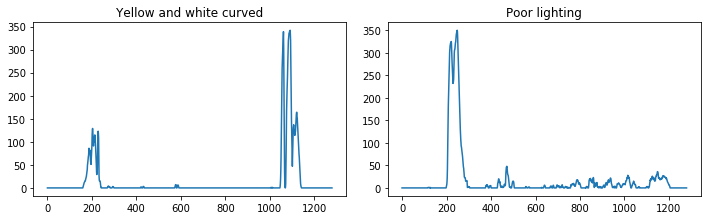

In [3]:
def undistort(image):
    calibration = pickle.load( open("calibration.p", "rb") )
    mtx = calibration['mtx']
    dist = calibration['dist']
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    return undist

def abs_sobel_thresh(image, orient = 'x', sobel_kernel=3, thresh = (0.7,5)):
    gray = cv2. cvtColor(image, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0 ,ksize = sobel_kernel)
    if orient =='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1 ,ksize = sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    abs_sobel_thresh = np.zeros_like(scaled_sobel)
    abs_sobel_thresh[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    return abs_sobel_thresh


def hls_thresh(image, channel="h", thresh=(0, 50)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    if channel=="h":
        thrshld_channel = hls[:,:,0]
    if channel=="l":
        thrshld_channel = hls[:,:,1]
    if channel=="s":
        thrshld_channel = hls[:,:,2]

    hls_threshold = np.zeros_like(thrshld_channel)
    hls_threshold[(thrshld_channel > thresh[0]) & (thrshld_channel < thresh[1])] = 1
    return hls_threshold

def combine_threshs(hls_thresh_1, abs_sobel_thresh_1):
    combined = np.zeros_like(hls_thresh_1)
    combined[hls_thresh_1 == 1] = 1
    combined[abs_sobel_thresh_1 == 1] = 1
    return combined

def filter(image):
    height, width = image.shape[0], image.shape[1]
    bl = (width / 2 - 480, height - 30)
    br = (width / 2 + 480, height - 30)
    tl = (width / 2 - 60, height / 2 + 76)
    tr = (width / 2 + 60, height / 2 + 76)

    fit_left = np.polyfit((bl[0], tl[0]), (bl[1], tl[1]), 1)
    fit_right = np.polyfit((br[0], tr[0]), (br[1], tr[1]), 1)
    fit_bottom = np.polyfit((bl[0], br[0]), (bl[1], br[1]), 1)
    fit_top = np.polyfit((tl[0], tr[0]), (tl[1], tr[1]), 1)

    # Find the region inside the lines
    x, y = np.meshgrid(np.arange(0, image.shape[1]), np.arange(0, image.shape[0]))
    mask = (y > (x * fit_left[0] + fit_left[1])) & \
           (y > (x * fit_right[0] + fit_right[1])) & \
           (y > (x * fit_top[0] + fit_top[1])) & \
           (y < (x * fit_bottom[0] + fit_bottom[1]))
    
    image_window = np.copy(image)
    image_window[mask == False] = 0

    return image_window

def get_hist(img):
    hist = np.sum(img[int(img.shape[0]//2):,:], axis=0)
    #hist = np.sum(img[img.shape[0]/2:,:], axis=0)
    return hist

def transform_image(windowed_image, M, img_size):
    return cv2.warpPerspective(windowed_image, M, img_size)


images = read_images()


undistorted_images = [undistort(image) for image in images]
abs_sobel_thresh_images = [abs_sobel_thresh(undistorted_image, orient=abs_sobel_orient, sobel_kernel = abs_sobel_kernel, thresh= abs_sobel_threshold) for undistorted_image in undistorted_images]
hls_thresh_images = [hls_thresh(undistorted_image, channel=hls_thresh_channel, thresh=hls_thresh_threshold) for undistorted_image in undistorted_images]
combined_images = [combine_threshs(hls_thresh, abs_sobel_thresh) for hls_thresh, abs_sobel_thresh in zip(hls_thresh_images, abs_sobel_thresh_images)]
windowed_images = [filter(combined) for combined in combined_images]
birds_view_images = [transform_image(windowed_image, M, img_size) for windowed_image in windowed_images]
histogram_images = [get_hist(birds_view_image) for birds_view_image in birds_view_images]


def plot_all(images = [], birds_view_images = [], option = 'transformation'):
    labels = ["Yellow and white", "Yellow and white curved", "Poor lighting", "Straight white", "Yellow and white curved 2", "Very poor lighting 1", "Very poor lighting 2", "Very poor lighting 3"]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,3))
    axes = axes.ravel()
    fig.tight_layout()

    if option == 'histogram':
        for ax, image, label in zip(axes, images[1:3], labels[1:3]):
            ax.plot(image)
            ax.set_title(label)
    plt.show()

plot_all(images = histogram_images, option = 'histogram') #plot transformations


In [4]:
def undistort1(image):

    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
    
def undistort2(image):

    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
    
def undistort3(image):
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=12)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=12)
    return undist
    
    
def undistort_rect(image):
    img_size = (image.shape[1], image.shape[0])
    undistorted_drawn = cv2.rectangle(np.copy(image), pt1=(0,img_size[1]), pt2=(img_size[0],img_size[1]-100), color=(255,0,0), thickness=3)
    return undistorted_drawn

def pers_transf(img):

    undist = undistort1(img)
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax1.set_title('Distortion removed', fontsize=12)
    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('No distortion and Perspective Transform applied', fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def pers_transf2(img):
    
    undist = undistort1(img)
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M
    
def binary_thresholds(image):
    img, M = pers_transf2(image)

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    # Plotting thresholded images
    f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
    f.tight_layout()

    ax1.set_title('Original Image', fontsize=12)
    ax1.imshow(cv2.cvtColor(undistort1(image),cv2.COLOR_BGR2RGB))

    ax2.set_title('Warped Image', fontsize=12)
    ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

    ax3.set_title('s binary threshold', fontsize=12)
    ax3.imshow(s_binary, cmap='gray')

    ax4.set_title('b binary threshold', fontsize=12)
    ax4.imshow(b_binary, cmap='gray')

    ax5.set_title('l binary threshold', fontsize=12)
    ax5.imshow(l_binary, cmap='gray')

    ax6.set_title('Combined color thresholds', fontsize=12)
    ax6.imshow(combined_binary, cmap='gray')        
    
def binary_thresholds_theo(image):
    img, M = pers_transf2(image)
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary   

def find_lanes(image):
    
    combined_binary = binary_thresholds_theo(image)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((pers_transf2(image)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=10)

class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

    
def make_video(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Center offset: {:.2f}m (left)'.format(distance_from_center), (40,60), fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Center offset: {:.2f}m (right)'.format(distance_from_center), (40,60),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Left Curvature: {}Km'.format(int((Left.radius))/1000), (40,100),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'Right Curvature: {}Km'.format(int((Right.radius))/1000), (40,140),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)

    Left.count += 1
    return result

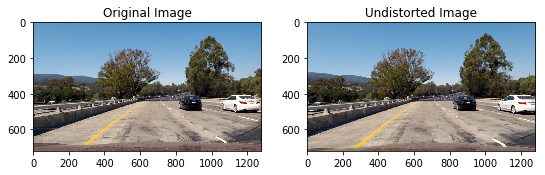

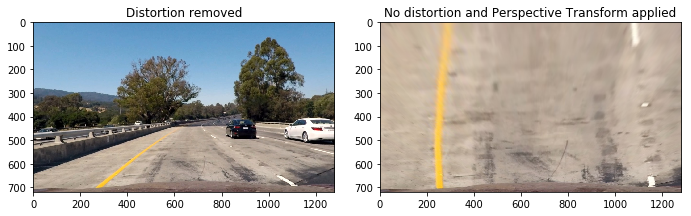

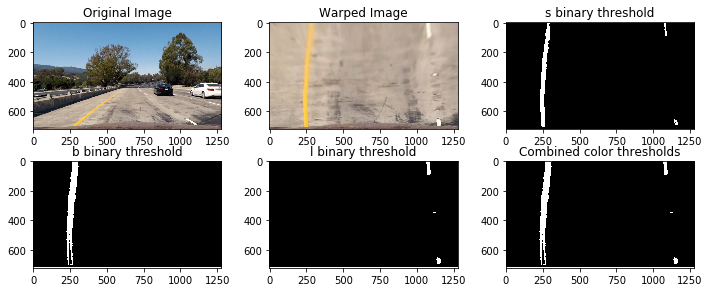

In [5]:
for image in glob.glob('test_images/test1.jpg'):
    undistort3(image)
    pers_transf(image)
    binary_thresholds(image)

In [6]:
Left = Line()
Right = Line()
video_output = 'project_video_OUTPUT.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(make_video) 
white_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_OUTPUT.mp4
[MoviePy] Writing video project_video_OUTPUT.mp4


100%|█████████▉| 1260/1261 [29:27<00:01,  1.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_OUTPUT.mp4 



In [7]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_OUTPUT.mp4'))